In [1]:
import numpy as xp
from scipy.ndimage import affine_transform
from scipy.interpolate import RegularGridInterpolator as RGI
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from skimage import measure
from pyqtgraph.Qt import QtWidgets
import pyqtgraph.opengl as gl
%matplotlib widget

# import cupy as xp
# from cupyx.scipy.ndimage import affine_transform
# from cupyx.scipy.interpolate import RegularGridInterpolator as RGI

def rotate_voxel(volume, rotation_matrix, output_size='same', fill_value=0):

    #Calculate output shape based on the input volume and the rotation matrix
    if output_size == 'full':
        corners = xp.array([[0, 0, 0],
                            [0, 0, volume.shape[2]],
                            [0, volume.shape[1], 0],
                            [volume.shape[0], 0, 0],
                            [volume.shape[0], volume.shape[1], 0],
                            [volume.shape[0], 0, volume.shape[2]],
                            [0, volume.shape[1], volume.shape[2]],
                            [volume.shape[0], volume.shape[1], volume.shape[2]]]).T
        
        rotated_corners = rotation_matrix @ corners
        min_coords = xp.min(rotated_corners, axis=1)
        max_coords = xp.max(rotated_corners, axis=1)
        output_shape = xp.ceil(max_coords - min_coords).astype(int)
    else:
        output_shape = volume.shape

    volume_shape = xp.array(volume.shape)


    # Pad the volume to match the output shape
    pad_width = xp.tile(xp.ceil((output_shape - volume_shape) / 2).astype(int), (2, 1)).T
    pad_width = tuple((max(int(p[0]), 0), max(int(p[1]), 0)) for p in pad_width)

    volume = xp.pad(volume, pad_width, mode='constant', constant_values=fill_value)
    new_center = xp.array(volume.shape) / 2

    # Perform the affine transformation
    rotated_volume = affine_transform(
        volume,
        matrix=rotation_matrix,
        offset=(new_center - xp.dot(rotation_matrix, new_center)),
        output_shape=volume.shape,
        order=1,
        cval=fill_value
    )

    return rotated_volume

# Example 3D volume
volume = xp.ones((100, 100, 10))

# Rotate the volume by 45 degrees around the Z-axis

random_angles = xp.array([45, 0, 0]) #xp.random.uniform(0, 20, size=3)
rotation = R.from_euler('xyz', random_angles, degrees=True)
rotation_matrix = rotation.as_matrix()
rotation_matrix = xp.array(rotation_matrix)
rotated_volume = rotate_voxel(volume, rotation_matrix, output_size='full', fill_value=0)


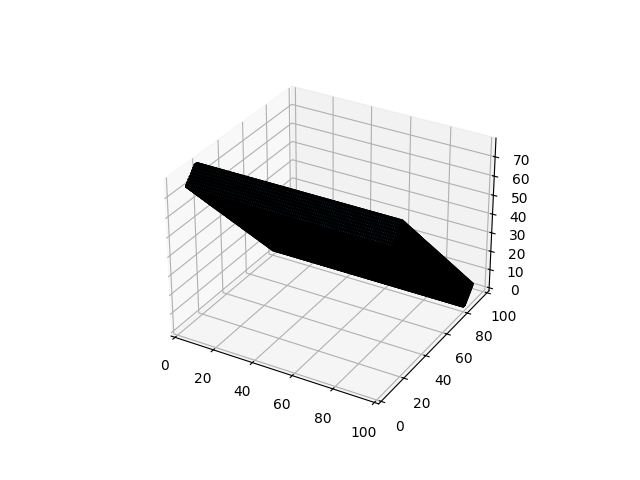

In [2]:
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(rotated_volume, edgecolor='k')
ax.set_xlim(0, rotated_volume.shape[0])
ax.set_ylim(0, rotated_volume.shape[1])
ax.set_zlim(0, rotated_volume.shape[2])

plt.show()


In [4]:

volume = xp.pad(volume, 1, mode='constant', constant_values=0)
mask = volume > 0
# Generate mesh from voxel grid using marching cubes
verts, faces, _, _ = measure.marching_cubes(volume)

# Convert vertices and faces to pyqtgraph format
mesh_data = gl.MeshData(vertexes=verts, faces=faces)

In [16]:
verts

verts_centre = verts.mean(axis=0)

verts_centre

array([50., 50.,  5.], dtype=float32)

In [ ]:
print(verts.shape)
print(xp.max(verts[:, 0]), xp.min(verts[:, 0]))
print(xp.max(verts[:, 1]), xp.min(verts[:, 1]))
print(xp.max(verts[:, 2]), xp.min(verts[:, 2]))

verts -= 0.5
print(xp.max(verts[:, 0]), xp.min(verts[:, 0]))
print(xp.max(verts[:, 1]), xp.min(verts[:, 1]))
print(xp.max(verts[:, 2]), xp.min(verts[:, 2]))

# # Initialize pyqtgraph application
app = QtWidgets.QApplication([])
window = gl.GLViewWidget()
window.show()

# Convert vertices and faces to pyqtgraph format
mesh_data = gl.MeshData(vertexes=verts, faces=faces)
# Create and add the mesh item
mesh_item = gl.GLMeshItem(meshdata=mesh_data, color=(0.8, 0.5, 0.3, 1.0), smooth=False, drawEdges=True)

# Define new Euler angles for rotation
new_angles = xp.array([45, 0, 0])  # Example angles in degrees

# Create a new rotation matrix from Euler angles
new_rotation = R.from_euler('xyz', new_angles, degrees=True)
new_rotation_matrix = new_rotation.as_matrix()
new_rotation_matrix = xp.array(new_rotation_matrix)

# Apply the rotation to the vertices
rotated_verts = verts @ new_rotation_matrix.T


# Update the mesh data with the rotated vertices
mesh_data.setVertexes(rotated_verts)

# Update the mesh item
mesh_item.setMeshData(meshdata=mesh_data)
window.addItem(mesh_item)

app.exec_()


(24000, 3)
100.5 0.5
100.5 0.5
10.5 0.5
100.0 0.0
100.0 0.0
10.0 0.0
100.0


C:\Users\dl277493\AppData\Local\Temp\ipykernel_47380\1129962385.py:38: DeprecationWarning: 'exec_' will be removed in the future. Use 'exec' instead.
  app.exec_()


0

In [12]:
print(xp.min(rotated_verts[:, 0]), xp.max(rotated_verts[:, 0]))
print(xp.min(rotated_verts[:, 1]), xp.max(rotated_verts[:, 1]))
print(xp.min(rotated_verts[:, 2]), xp.max(rotated_verts[:, 2]))

0.0 100.0
-6.717514421272202 70.35712472806148
0.35355339059327373 77.42819253992695


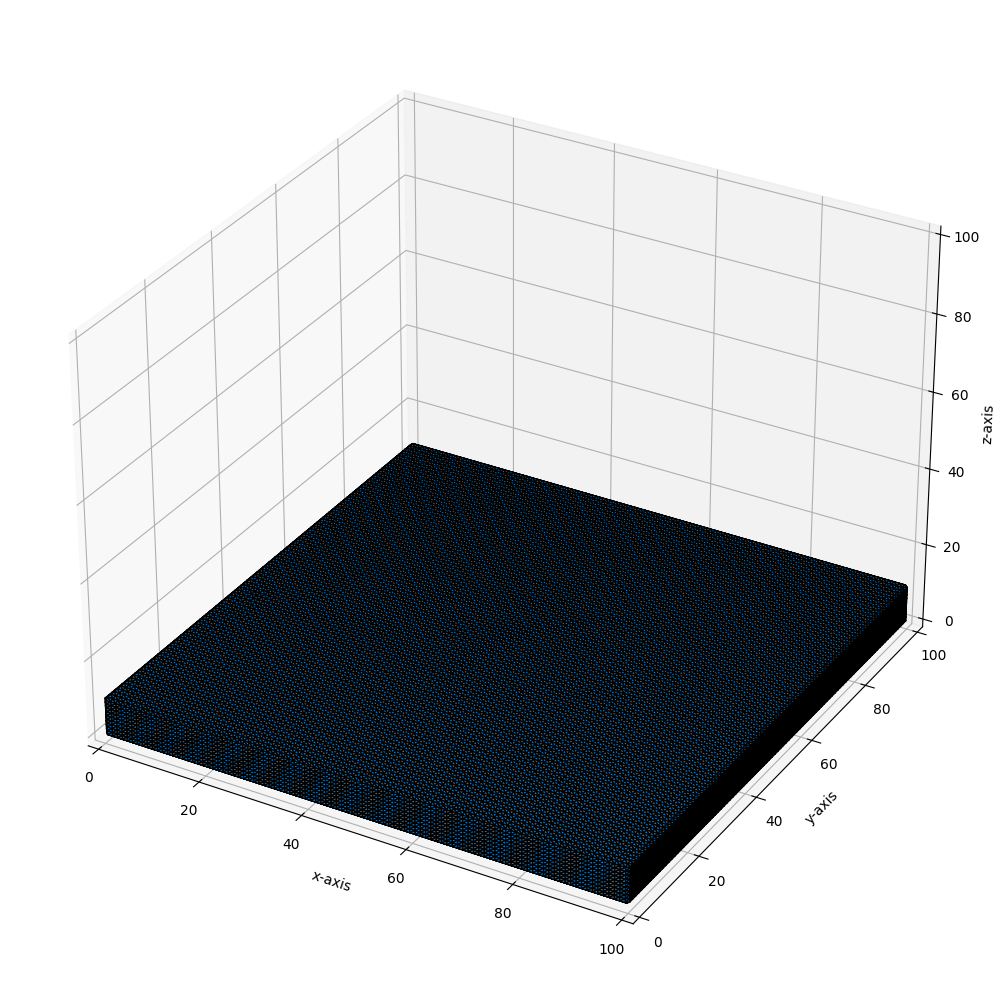

In [6]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis")
ax.set_ylabel("y-axis")
ax.set_zlabel("z-axis")

ax.set_xlim(0, 100)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 100)  # b = 10
ax.set_zlim(0, 100)  # c = 16

plt.tight_layout()
plt.show()